In [1]:
import pandas as pd
import train
import holidays

df = pd.read_csv('cleaneddata.csv')
# df
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import classification_report, mean_absolute_error, mean_squared_error
from matplotlib import pyplot as plt
de_holidays = holidays.Germany(prov='NW')


/var/folders/_4/yzd4h3k95051tj7kpg425rk80000gn/T/ipykernel_90596/1292713691.py:5: DtypeWarning: Columns (11,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('cleaneddata.csv')



--- Step 1: Cancellation Prediction Analysis ---
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99   1113107
           1       0.02      0.01      0.01     21127

    accuracy                           0.98   1134234
   macro avg       0.50      0.50      0.50   1134234
weighted avg       0.96      0.98      0.97   1134234


Feature Importances for Cancellation Prediction:
             feature  importance
16  hist_cancel_rate       0.245
12        order_hour       0.183
3        day_of_year       0.153
0          MenuPrice       0.120
1        MenuSubsidy       0.104
4            weekday       0.061
2        subsidy_pct       0.045
8              month       0.042
9            quarter       0.014
14         afternoon       0.009
13           morning       0.008
15           evening       0.006
5         is_weekend       0.005
11    is_month_start       0.003
10      is_month_end       0.002
17        is_holiday  

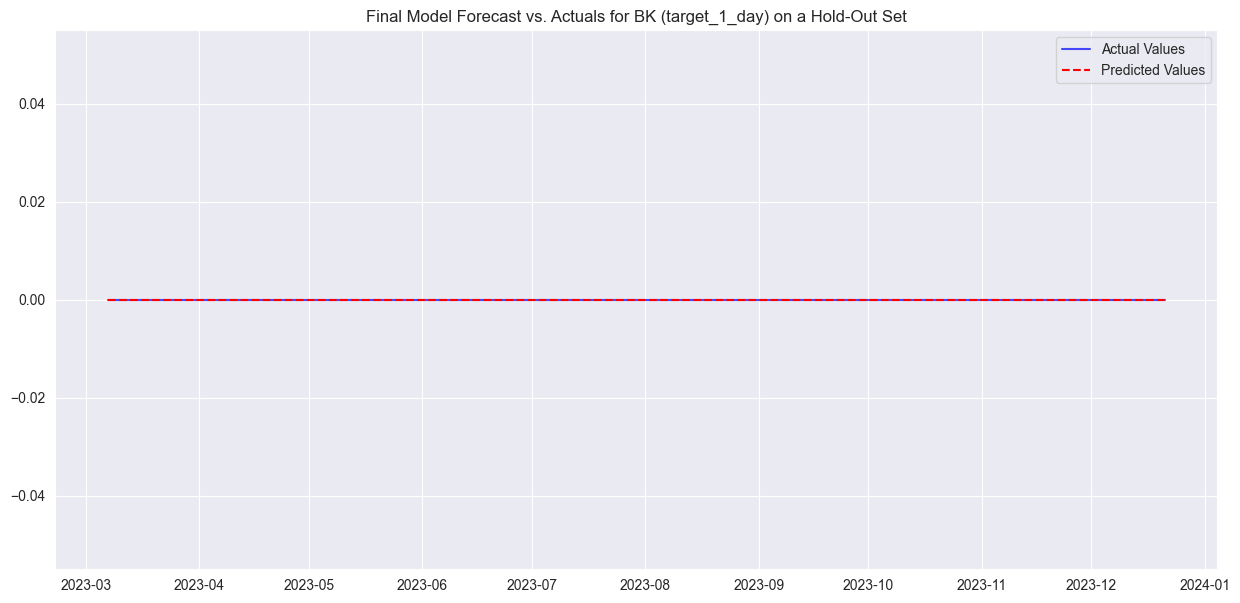


--- End of Step 5 ---

--- Step 6: Generating Future Forecasts ---
Predicting future demand...

Sample Forecast for the next available day:
   target_1_day target_2_5_days target_6_10_days
BK      0 meals         0 meals          0 meals
LP      0 meals         0 meals          0 meals
MS      0 meals         0 meals          0 meals

--- End of Step 6 ---


In [3]:
 import numpy as np

# --- 1. CANCELLATION PREDICTION ANALYSIS ---
print("\n--- Step 1: Cancellation Prediction Analysis ---")
df['is_canceled'] = (df['CanceledQty'] > 0).astype(int)

# Feature selection for cancellation model
cancel_features = [
    'MenuPrice', 'MenuSubsidy', 'subsidy_pct', 'day_of_year', 'weekday',
    'is_weekend', 'sin_doy', 'cos_doy', 'month', 'quarter', 'is_month_end',
    'is_month_start', 'order_hour', 'morning', 'afternoon', 'evening',
    'hist_cancel_rate', 'is_holiday'
]
target_cancel = 'is_canceled'

X_cancel = df[cancel_features].copy()
y_cancel = df[target_cancel]

# Impute missing and infinite values
X_cancel.replace([np.inf, -np.inf], np.nan, inplace=True)
X_cancel = X_cancel.ffill().bfill()
for col in X_cancel.columns:
    if X_cancel[col].isnull().any():
        if pd.api.types.is_numeric_dtype(X_cancel[col]):
            X_cancel[col] = X_cancel[col].fillna(0)
        else:
            X_cancel[col] = X_cancel[col].fillna(X_cancel[col].mode()[0])

# Time Series Split for classification
split_index = int(len(df) * 0.8)
X_train_c, X_test_c = X_cancel[:split_index], X_cancel[split_index:]
y_train_c, y_test_c = y_cancel[:split_index], y_cancel[split_index:]

# Model Training
rf_classifier = RandomForestClassifier(
    n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1)
rf_classifier.fit(X_train_c, y_train_c)

# Evaluation
y_pred_c = rf_classifier.predict(X_test_c)
print("Classification Report:")
print(classification_report(y_test_c, y_pred_c))

# Feature Importance
feature_importances = pd.DataFrame({
    'feature': cancel_features,
    'importance': rf_classifier.feature_importances_
}).sort_values('importance', ascending=False)
print("\nFeature Importances for Cancellation Prediction:")
print(feature_importances.round(3))
print("\n--- End of Step 1 ---")

# --- 2. DATA PREPARATION FOR FORECASTING ---
print("\n--- Step 2: Data Preparation for Forecasting ---")
daily_demand = df.groupby(['DateOfService', 'Site'], observed=False)['net_qty'].sum().reset_index()
pivot_demand = daily_demand.pivot(index='DateOfService', columns='Site', values='net_qty').fillna(0)
full_date_range = pd.date_range(start=pivot_demand.index.min(), end=pivot_demand.index.max(), freq='D')
pivot_demand = pivot_demand.reindex(full_date_range, fill_value=0)
print("Pivoted daily demand data created.")

# Feature Engineering for time-based features (non-leaky)
time_features = pd.DataFrame(index=pivot_demand.index)
time_features['day_of_year'] = time_features.index.dayofyear
time_features['weekday'] = time_features.index.weekday
time_features['is_weekend'] = time_features.index.weekday >= 5
time_features['month'] = time_features.index.month
time_features['quarter'] = time_features.index.quarter
time_features['day_of_month'] = time_features.index.day
time_features['sin_doy'] = np.sin(2 * np.pi * time_features['day_of_year'] / 365.25)
time_features['cos_doy'] = np.cos(2 * np.pi * time_features['day_of_year'] / 365.25)
time_features['is_holiday'] = time_features.index.to_series().apply(lambda x: int(x in de_holidays))
time_features = time_features.ffill().bfill().fillna(0)

# Create Target Variables
targets_1_day = pivot_demand.shift(-1)
targets_2_5_days = pivot_demand.rolling(window=4, min_periods=1).mean().shift(-5)
targets_6_10_days = pivot_demand.rolling(window=5, min_periods=1).mean().shift(-10)
target_dfs = {
    'target_1_day': targets_1_day,
    'target_2_5_days': targets_2_5_days,
    'target_6_10_days': targets_6_10_days,
}
print("Target variables created.")
print("\n--- End of Step 2 ---")

# --- 3. & 4. TIME SERIES CROSS-VALIDATION & MODEL TRAINING (CORRECTED) ---
print("\n--- Steps 3 & 4: Time Series Cross-Validation & Final Model Training ---")

sites = pivot_demand.columns
models = {}  # To store our final trained models
evaluation_results = []  # To store the average performance from CV
reg_features = []  # To store a definitive list of feature names

tscv = TimeSeriesSplit(n_splits=5)

for site in sites:
    print(f"\n--- Processing Site: {site} ---")
    models[site] = {}

    # Create site-specific features to prevent data leakage
    site_features = time_features.copy()
    for lag in [1, 2, 3, 7, 14]:
        site_features[f'site_lag_{lag}'] = pivot_demand[site].shift(lag)
    site_features['site_rolling_mean_7'] = pivot_demand[site].shift(1).rolling(window=7).mean()
    site_features['site_rolling_mean_14'] = pivot_demand[site].shift(1).rolling(window=14).mean()
    site_features = site_features.ffill().bfill().fillna(0)

    # *** ADDED FIX: Store the list of all feature names *once* to ensure consistency ***
    if not reg_features:
        reg_features = site_features.columns.tolist()

    for horizon_name, target_df in target_dfs.items():
        print(f"  Processing model for horizon: {horizon_name}")
        y_series = target_df[site]
        temp_df = pd.concat([site_features, y_series.rename('target')], axis=1)
        temp_df.dropna(subset=['target'], inplace=True)

        # Use the predefined feature list to ensure consistency
        X = temp_df[reg_features]
        y = temp_df['target']

        mae_scores = []
        for fold, (train_index, test_index) in enumerate(tscv.split(X)):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            rf_regressor_fold = RandomForestRegressor(
                n_estimators=100, random_state=42, n_jobs=-1, min_samples_leaf=5)
            rf_regressor_fold.fit(X_train, y_train)
            y_pred_fold = rf_regressor_fold.predict(X_test)
            mae_scores.append(mean_absolute_error(y_test, y_pred_fold))

        average_mae = np.mean(mae_scores)
        std_mae = np.std(mae_scores)
        print(f"  > CV Average MAE for {horizon_name}: {average_mae:.2f} (+/- {std_mae:.2f})")
        evaluation_results.append({
            'Site': site, 'Horizon': horizon_name, 'Average_MAE': average_mae, 'Std_MAE': std_mae})

        # Train the final model on ALL available data (X, y)
        final_model = RandomForestRegressor(
            n_estimators=100, random_state=42, n_jobs=-1, min_samples_leaf=5)
        final_model.fit(X, y)
        models[site][horizon_name] = {'model': final_model}

print("\nAll models have been evaluated with CV and final versions are trained.")
print("\n--- End of Steps 3 & 4 ---")

# --- 5. MODEL EVALUATION ---
print("\n--- Step 5: Model Evaluation ---")
results_df = pd.DataFrame(evaluation_results)
print("\nForecasting Model Performance (from Cross-Validation):")
print(results_df.round(2))

# Visualize predictions for one example
if not models or not evaluation_results:
    print("No models were trained, skipping visualization.")
else:
    site_to_plot = results_df['Site'].iloc[0]
    horizon_to_plot = 'target_1_day'

    # Re-create features and data for the plot
    site_features_plot = time_features.copy()
    for lag in [1, 2, 3, 7, 14]:
        site_features_plot[f'site_lag_{lag}'] = pivot_demand[site_to_plot].shift(lag)
    site_features_plot['site_rolling_mean_7'] = pivot_demand[site_to_plot].shift(1).rolling(window=7).mean()
    site_features_plot['site_rolling_mean_14'] = pivot_demand[site_to_plot].shift(1).rolling(window=14).mean()
    site_features_plot = site_features_plot.ffill().bfill().fillna(0)
    y_series_plot = target_dfs[horizon_to_plot][site_to_plot]
    temp_df_plot = pd.concat([site_features_plot, y_series_plot.rename('target')], axis=1)
    temp_df_plot.dropna(subset=['target'], inplace=True)

    # Use the definitive feature list
    X_plot = temp_df_plot[reg_features]
    y_plot = temp_df_plot['target']

    plot_split_index = int(len(X_plot) * 0.8)
    X_test_plot, y_test_plot = X_plot[plot_split_index:], y_plot[plot_split_index:]

    final_model_to_plot = models[site_to_plot][horizon_to_plot]['model']
    y_pred_plot = final_model_to_plot.predict(X_test_plot)

    plt.figure(figsize=(15, 7))
    plt.plot(y_test_plot.index, y_test_plot, label='Actual Values', color='blue', alpha=0.7)
    plt.plot(y_test_plot.index, y_pred_plot, label='Predicted Values', color='red', linestyle='--')
    plt.title(f'Final Model Forecast vs. Actuals for {site_to_plot} ({horizon_to_plot}) on a Hold-Out Set')
    plt.legend()
    plt.grid(True)
    plt.show()

print("\n--- End of Step 5 ---")

# --- 6. GENERATING FUTURE FORECASTS (CORRECTED) ---
print("\n--- Step 6: Generating Future Forecasts ---")

last_date = pivot_demand.index.max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=14, freq='D')
future_features_base = pd.DataFrame(index=future_dates)
future_features_base['day_of_year'] = future_features_base.index.dayofyear
future_features_base['weekday'] = future_features_base.index.weekday
future_features_base['is_weekend'] = future_features_base.index.weekday >= 5
future_features_base['month'] = future_features_base.index.month
future_features_base['quarter'] = future_features_base.index.quarter
future_features_base['day_of_month'] = future_features_base.index.day
future_features_base['sin_doy'] = np.sin(2 * np.pi * future_features_base['day_of_year'] / 365.25)
future_features_base['cos_doy'] = np.cos(2 * np.pi * future_features_base['day_of_year'] / 365.25)
future_features_base['is_holiday'] = future_features_base.index.to_series().apply(lambda x: int(x in de_holidays))

print("Predicting future demand...")
future_predictions = {}
for site in models:
    future_predictions[site] = {}
    temp_future_features = future_features_base.copy()
    full_series = pd.concat([pivot_demand[site], pd.Series(index=temp_future_features.index, dtype='float64')])

    # Create future lagged/rolling features with consistent names
    for lag in [1, 2, 3, 7, 14]:
        temp_future_features[f'site_lag_{lag}'] = full_series.shift(lag)[temp_future_features.index]
    temp_future_features['site_rolling_mean_7'] = full_series.shift(1).rolling(window=7).mean()[
        temp_future_features.index]
    temp_future_features['site_rolling_mean_14'] = full_series.shift(1).rolling(window=14).mean()[
        temp_future_features.index]
    temp_future_features = temp_future_features.ffill().bfill().fillna(0)

    for horizon, model_info in models[site].items():
        model = model_info['model']
        # *** ADDED FIX: Use the saved feature list to ensure column order and names match ***
        X_future = temp_future_features[reg_features]
        predictions = model.predict(X_future)
        future_predictions[site][horizon] = predictions

forecast_day_1 = pd.DataFrame({
    site: {
        horizon: f"{int(preds[0])} meals" for horizon, preds in site_preds.items()
    } for site, site_preds in future_predictions.items()
}).T

print("\nSample Forecast for the next available day:")
print(forecast_day_1)
print("\n--- End of Step 6 ---")
